In [124]:
# Import required modules.
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
# Read the data into de.
de = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [3]:
# Show the head of de.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [4]:
# Show the shape of de.
de.shape

(100689, 34)

In [5]:
# Check for duplicates in de.
de[de.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

 - No duplicates found

In [6]:
# Check for missing values in de.
de.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

 - No missing values shown

In [7]:
# Get the statistics of de.
ds = de.describe().round()

In [8]:
# Show statistics of the first 16 columns.
ds.iloc[:, :16]

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,174.0,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0
std,52.0,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0
min,100.0,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0
25%,115.0,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0
50%,203.0,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0
75%,219.0,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0
max,234.0,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0


In [9]:
# Show statistics of the last 17 columns.
ds.iloc[:, 17:]

,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,82.0,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,267.0,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,324.0,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [10]:
# Check the value counts of the target column.
de.type.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

- N represents normal while VEB, SVEB, F, and Q represents arrhythmia

In [11]:
# Transform multi-class labels into binary-class (1 and 0).
de['type'] = de.type.map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [12]:
# Check the value counts of the target column.
de.type.value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [13]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']

    sm = SMOTE(random_state=22)
    df_full_train_sm, y_full_train_sm = sm.fit_resample(df_full_train, y_full_train)
    df_train_sm, y_train_sm = sm.fit_resample(df_train, y_train)
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train_sm.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train_sm.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train_sm, y_test, y_train_sm, y_val, dv

In [14]:
# Create function to get the score.
def get_score(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_val, y_pred

## First Training

### Logistic Regression Algorithm

In [15]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.955


### Random Forest Classifier

In [16]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9977


### Gradient Boosting Classifier

In [17]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9906


### XGB Classifier

In [112]:
# Define a function to create dtrain and dval.
def get_dicts(df):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval, y_val

In [113]:
# Create function to get xgb score.
def xgb_score(xgb_params):
    dtrain, dval, y_val = get_dicts(df)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    score = roc_auc_score(y_val, y_pred)

    return score, y_val, y_pred

In [114]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_gbc = 0.995


In [115]:
# Define numerical columns and split into two sets.
col_num = de.drop(columns="type").columns.to_list()
set_one = col_num[:16]
set_two = col_num[17:]

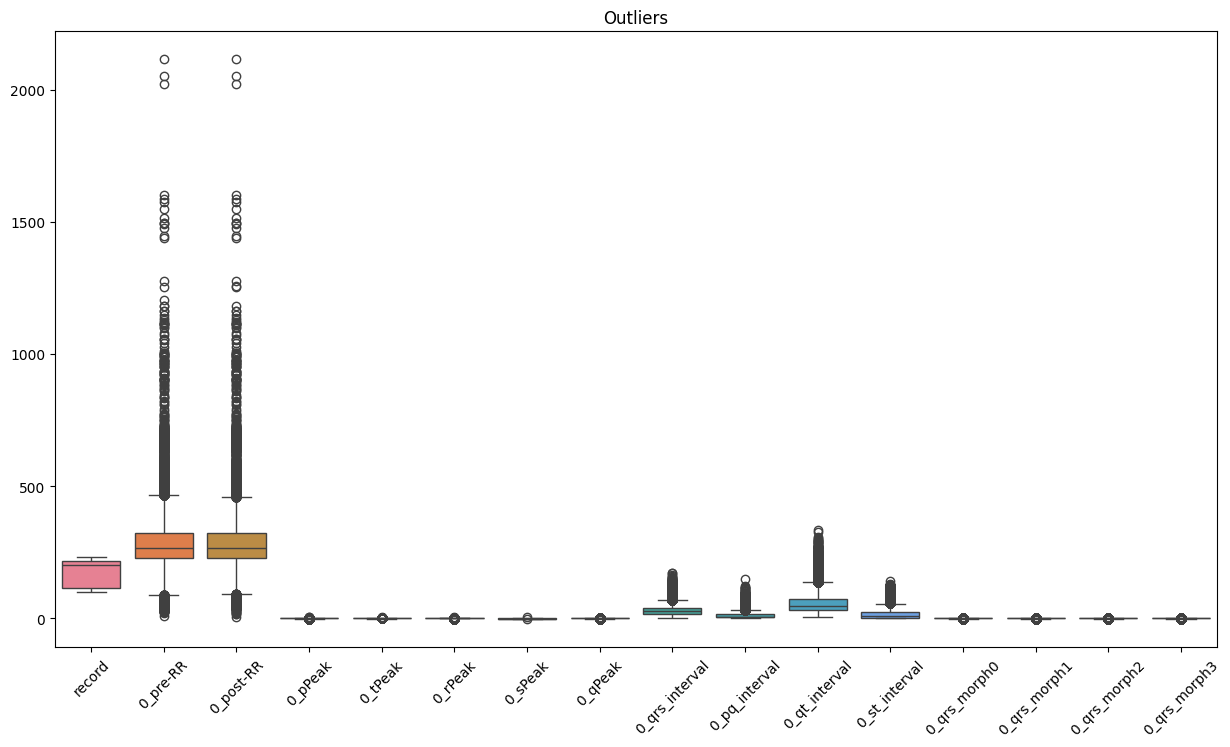

In [22]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

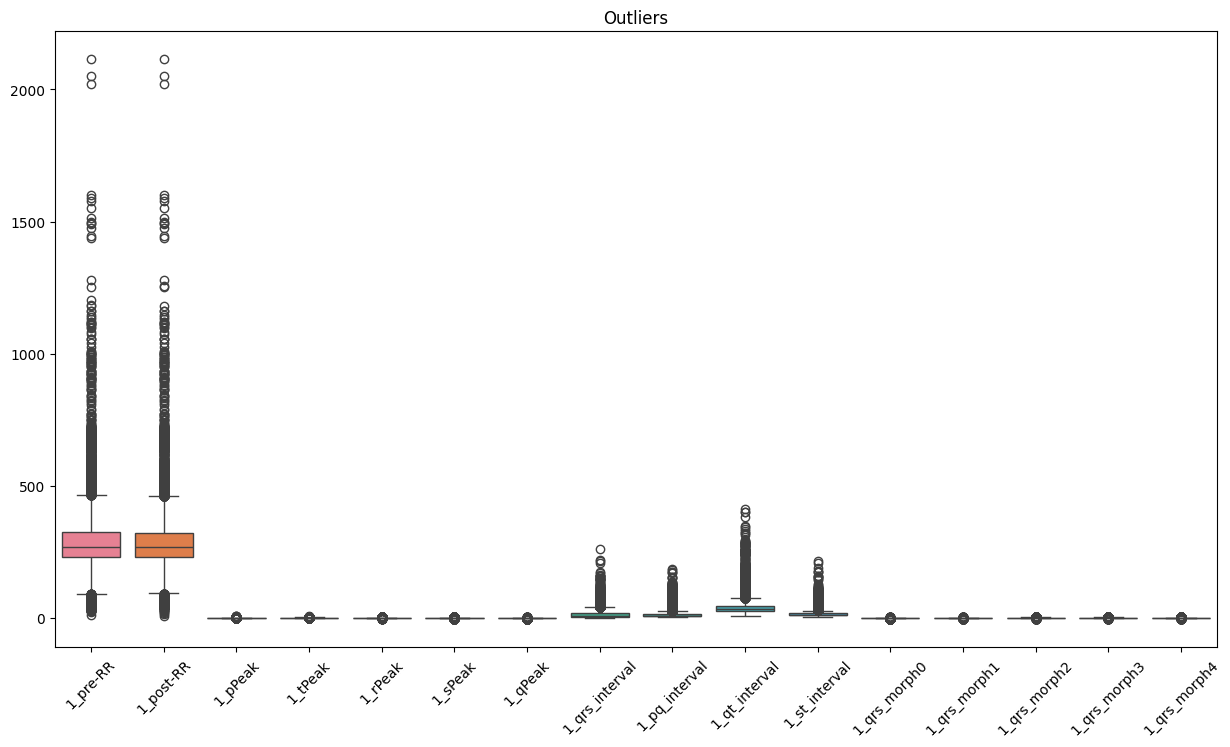

In [23]:
# Draw boxplot of the second set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

In [24]:
# Define function to remove outlier.
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    lower  = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    df_remove = df_in[~((df_in[col_name] < lower) | (df_in[col_name] > upper))]
    return df_remove

In [25]:
# Remove outliers.
for col in de.columns.to_list():
    dr = remove_outlier(de, col)

de = dr

In [26]:
# Show the shape of new dataframe.
de.shape

(93702, 34)

## Second Training

### Logistic Regression Algorithm

In [27]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.962


### Random Forest Classifier

In [28]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9983


### Gradient Boosting Classifier

In [29]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.992


### XGB Classifier

In [30]:
# Calculate the ROC AUC score.
df = dr.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_gbc, y_val, y_pred = xgb_score(xgb_params)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9951


In [31]:
# Check for correletion.
corr = de[col_num].corr().round(2)

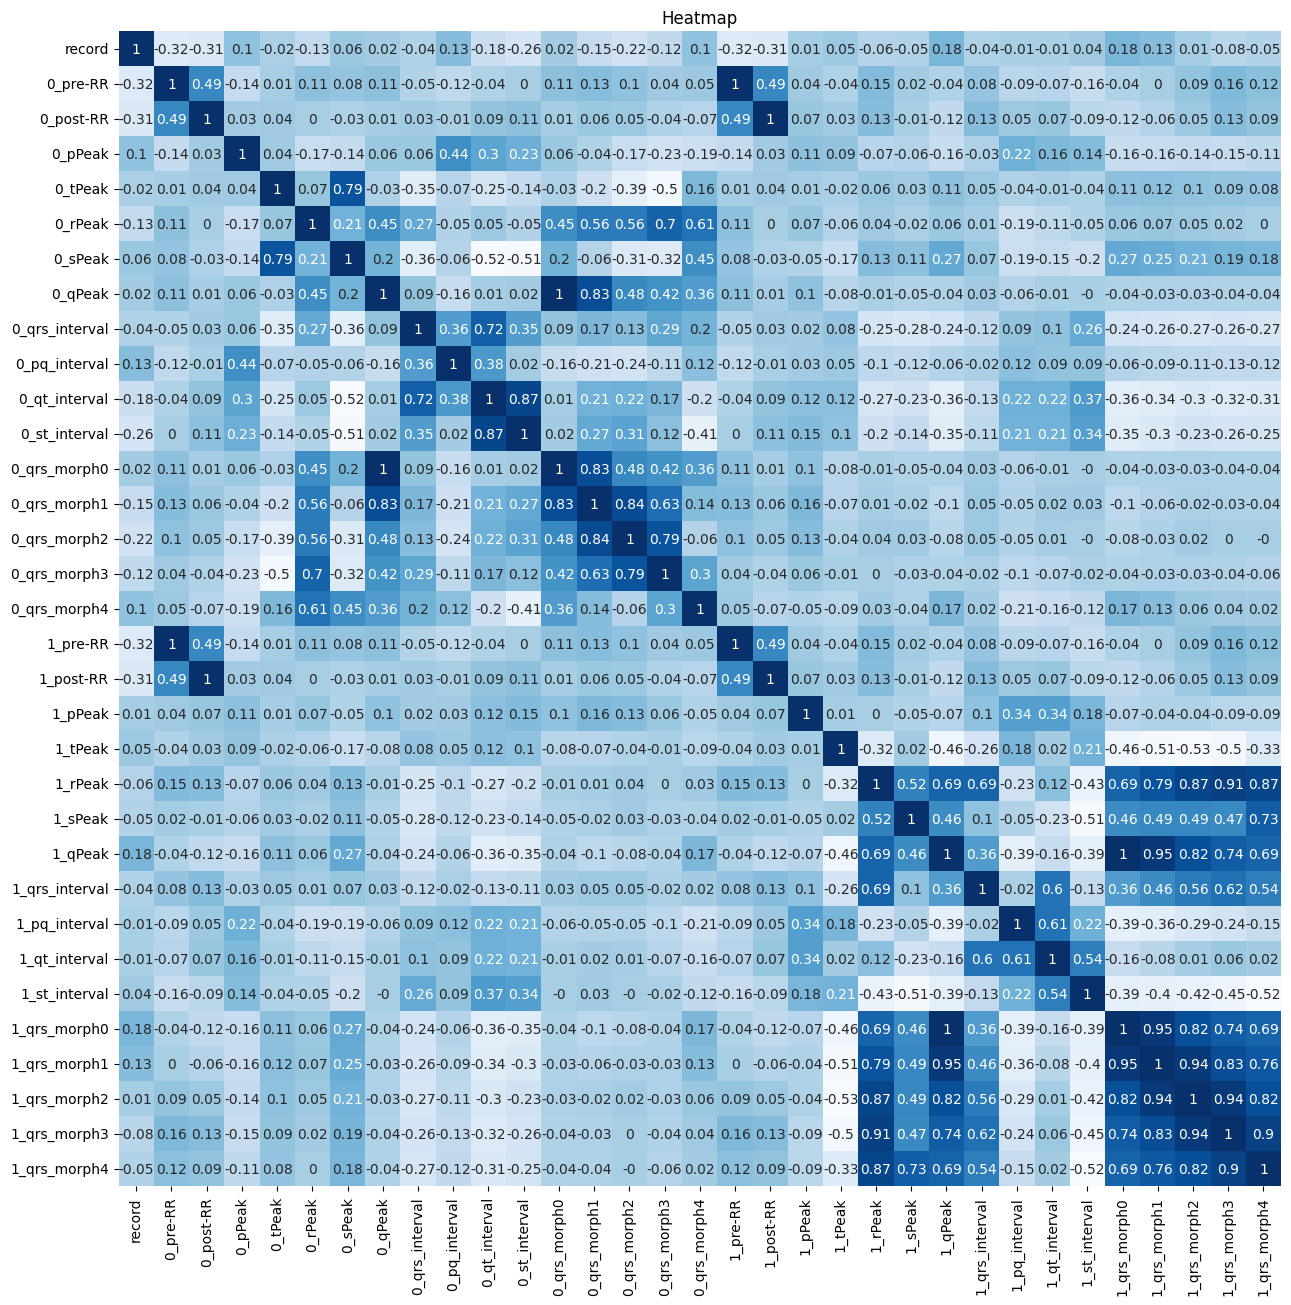

In [32]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
plt.title('Heatmap')
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False);

In [33]:
# Unstack the correlation values.
du = corr.unstack().sort_values(ascending=False)

In [34]:
# Check the length of df_unstack.
len(du)

1089

In [35]:
# Show the first 40 records of df_unstack.
du[:40]

1_qrs_morph4    1_qrs_morph4      1.0
1_qrs_morph3    1_qrs_morph3      1.0
1_qrs_morph2    1_qrs_morph2      1.0
1_qrs_morph1    1_qrs_morph1      1.0
1_qrs_morph0    1_qrs_morph0      1.0
                1_qPeak           1.0
1_st_interval   1_st_interval     1.0
1_qt_interval   1_qt_interval     1.0
1_pq_interval   1_pq_interval     1.0
1_qrs_interval  1_qrs_interval    1.0
1_qPeak         1_qrs_morph0      1.0
                1_qPeak           1.0
1_sPeak         1_sPeak           1.0
1_rPeak         1_rPeak           1.0
1_tPeak         1_tPeak           1.0
1_pPeak         1_pPeak           1.0
1_post-RR       1_post-RR         1.0
                0_post-RR         1.0
0_pre-RR        0_pre-RR          1.0
1_pre-RR        1_pre-RR          1.0
                0_pre-RR          1.0
0_qrs_morph4    0_qrs_morph4      1.0
0_qrs_morph3    0_qrs_morph3      1.0
0_qrs_morph2    0_qrs_morph2      1.0
0_qrs_morph1    0_qrs_morph1      1.0
0_qrs_morph0    0_qrs_morph0      1.0
            

In [36]:
# Show the next 40 records of df_unstack.
du[41:80]

1_qPeak        1_qrs_morph1     0.95
1_qrs_morph1   1_qrs_morph0     0.95
               1_qPeak          0.95
1_qrs_morph0   1_qrs_morph1     0.95
1_qrs_morph1   1_qrs_morph2     0.94
1_qrs_morph2   1_qrs_morph3     0.94
1_qrs_morph3   1_qrs_morph2     0.94
1_qrs_morph2   1_qrs_morph1     0.94
1_qrs_morph3   1_rPeak          0.91
1_rPeak        1_qrs_morph3     0.91
1_qrs_morph3   1_qrs_morph4     0.90
1_qrs_morph4   1_qrs_morph3     0.90
0_st_interval  0_qt_interval    0.87
1_rPeak        1_qrs_morph4     0.87
               1_qrs_morph2     0.87
1_qrs_morph4   1_rPeak          0.87
1_qrs_morph2   1_rPeak          0.87
0_qt_interval  0_st_interval    0.87
0_qrs_morph1   0_qrs_morph2     0.84
0_qrs_morph2   0_qrs_morph1     0.84
0_qrs_morph0   0_qrs_morph1     0.83
0_qPeak        0_qrs_morph1     0.83
1_qrs_morph1   1_qrs_morph3     0.83
1_qrs_morph3   1_qrs_morph1     0.83
0_qrs_morph1   0_qrs_morph0     0.83
               0_qPeak          0.83
1_qrs_morph0   1_qrs_morph2     0.82
1

In [37]:
# List the highly correlated columns.
remove_corr = ['1_pre-RR', '1_post-RR', '0_qrs_morph0', '1_qrs_morph0', 
               '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [38]:
# Remove the highly correlated columns.
de = de.drop(columns=remove_corr)

 - This is the final data

In [39]:
# Show the shape of de.
de.shape

(93702, 26)

## Logistic Regression

### Train Model

In [40]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9566


In [41]:
# Define ROC curve plot function.
def roc_curve_draw(y_val, y_pred):
    plt.figure(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label='probability')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.title('ROC Curve')
    plt.legend()
    
    return plt.show()

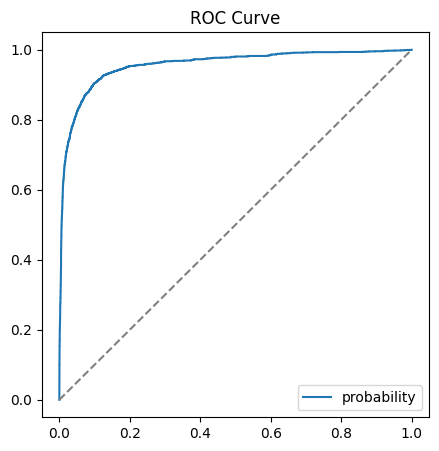

In [42]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [43]:
# Define the confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [44]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1753,1846,170,14972
20,0.2,1558,782,365,16036
30,0.3,1421,439,502,16379
40,0.4,1335,302,588,16516
50,0.5,1250,223,673,16595
60,0.6,1181,177,742,16641
70,0.7,1054,141,869,16677
80,0.8,934,101,989,16717
90,0.9,683,73,1240,16745


### Precision and Recall

In [45]:
# Define the precision-recall plot function.
def pre_rec_plot(df_scores):
    # Calculate the precision and recall.
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)  
    
    # Plot the curves.
    plt.plot(df_scores.threshold, df_scores.p, label='precision')
    plt.plot(df_scores.threshold, df_scores.r, label='recall')

    plt.title('Precision-Recall Curves')
    plt.legend()
    
    return plt.show()

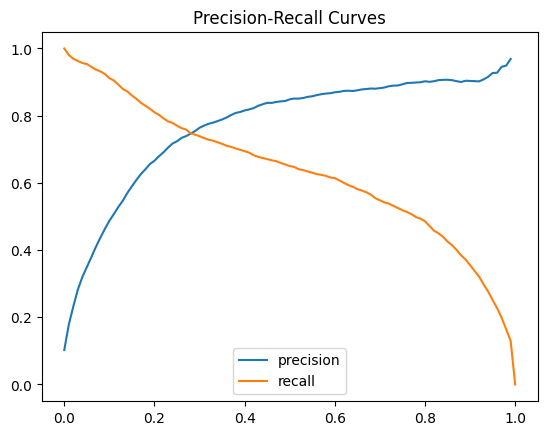

In [46]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [47]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [48]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

f1_max_lr = 0.7516


In [49]:
# Define the f1 plot function.
def f1_plot(df_scores):
    plt.plot(df_scores.threshold, df_scores.f1)
    plt.xticks(np.linspace(0, 1, 11))
    plt.title('F1 Curve')
    
    return plt.show()

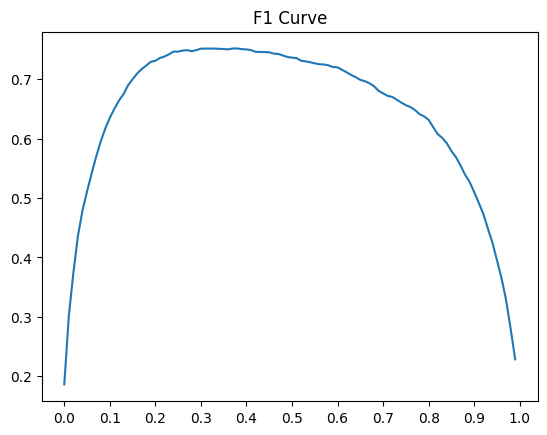

In [50]:
# Plot the F1 scores.
f1_plot(df_scores)

## Random Forest Classifier

### Train Model

In [51]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred = get_score(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9981


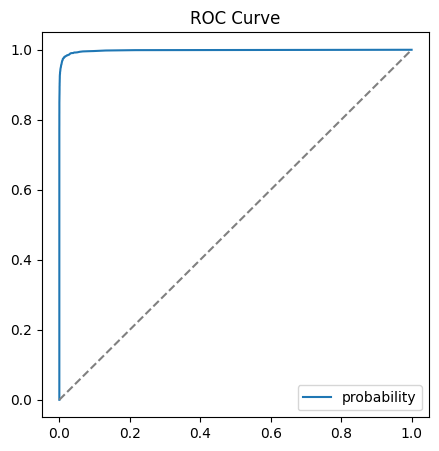

In [52]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [53]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1905,659,18,16159
20,0.2,1889,323,34,16495
30,0.3,1874,175,49,16643
40,0.4,1840,88,83,16730
50,0.5,1808,45,115,16773
60,0.6,1752,18,171,16800
70,0.7,1669,6,254,16812
80,0.8,1543,1,380,16817
90,0.9,1359,0,564,16818


### Precision and Recall

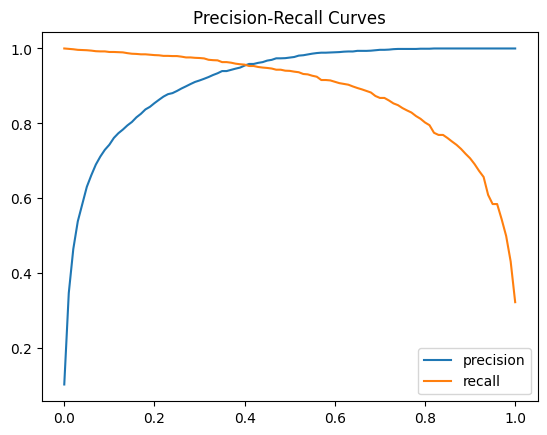

In [54]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [55]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [56]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9583


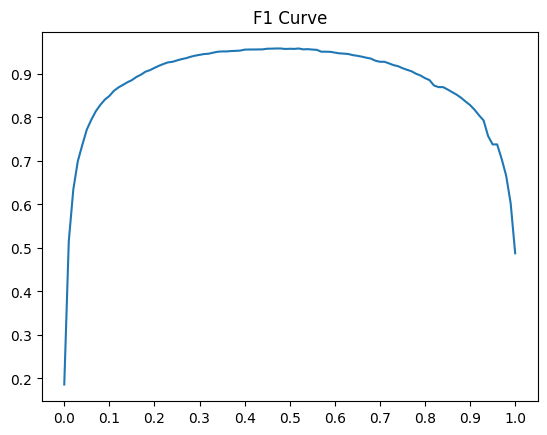

In [57]:
# Plot the F1 scores.
f1_plot(df_scores)

## Gradient Boosting Classifier

In [58]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred = get_score(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.992


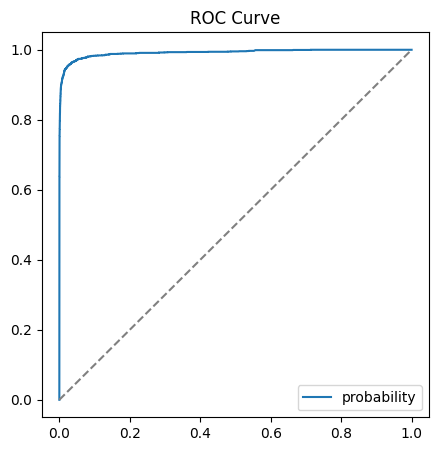

In [59]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [60]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1850,569,73,16249
20,0.2,1815,277,108,16541
30,0.3,1769,152,154,16666
40,0.4,1729,85,194,16733
50,0.5,1679,60,244,16758
60,0.6,1619,39,304,16779
70,0.7,1548,28,375,16790
80,0.8,1447,11,476,16807
90,0.9,1273,7,650,16811


### Precision and Recall

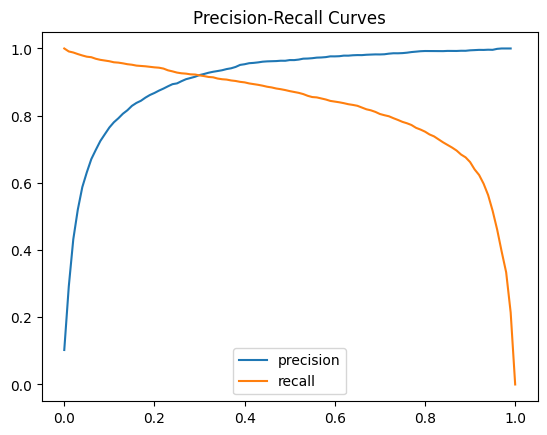

In [61]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [62]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [63]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9253


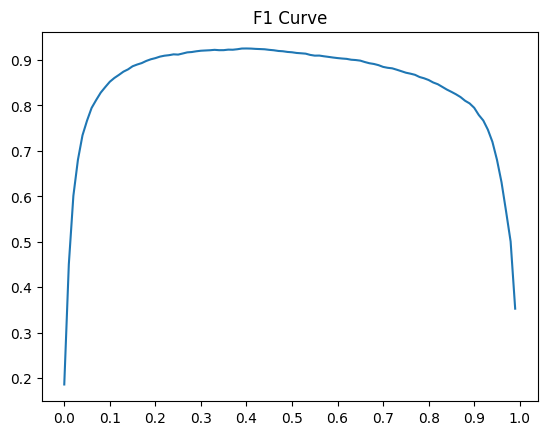

In [64]:
# Plot the F1 scores.
f1_plot(df_scores)

### XGB Classifier

In [83]:
# Calculate the ROC AUC score.
df = dr.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred = xgb_score(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9951


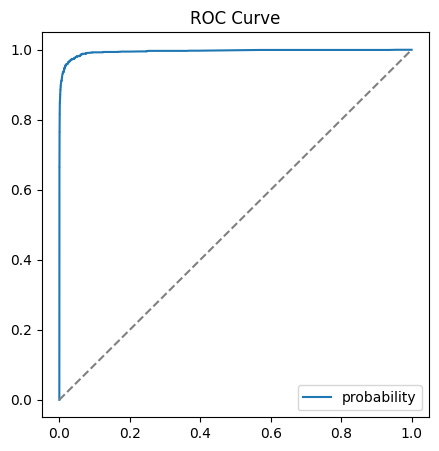

In [84]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [85]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1923,16818,0,0
10,0.1,1860,498,63,16320
20,0.2,1822,248,101,16570
30,0.3,1781,142,142,16676
40,0.4,1750,97,173,16721
50,0.5,1720,63,203,16755
60,0.6,1681,43,242,16775
70,0.7,1635,25,288,16793
80,0.8,1556,16,367,16802
90,0.9,1345,6,578,16812


### Precision and Recall

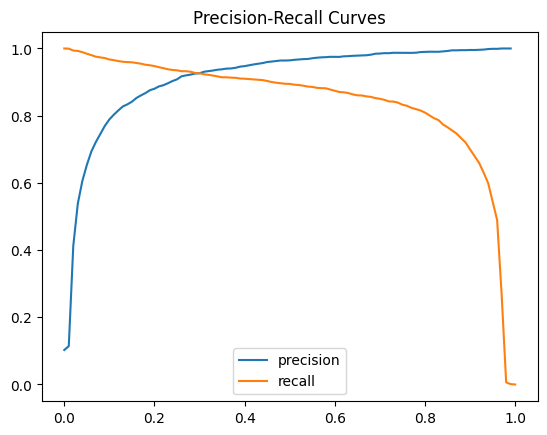

In [86]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [87]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [88]:
# Get the maximum f1-score.
f1_max_xgb = df_scores['f1'].max()
print(f'f1_max_xgb = {round(f1_max_xgb, 4)}')

f1_max_xgb = 0.9306


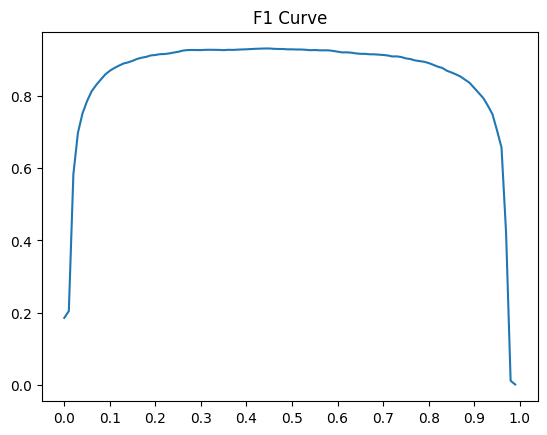

In [89]:
# Plot the F1 scores.
f1_plot(df_scores)

## Feature Importances

### Logistic Regression

In [72]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [73]:
# Apply the feature elimination technique.
original_score = score_lra
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values
    
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [74]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_lr,difference
1,0_pre-RR,0.910614,0.045986
2,0_post-RR,0.945590,0.011010
0,record,0.946017,0.010583
5,0_rPeak,0.947863,0.008737
4,0_tPeak,0.952005,0.004595
17,1_tPeak,0.953745,0.002855
3,0_pPeak,0.954230,0.002370
18,1_rPeak,0.955565,0.001035
15,0_qrs_morph4,0.955749,0.000851
13,0_qrs_morph2,0.955918,0.000682


### Random Forest Classifier

In [75]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [76]:
# Apply the feature elimination technique.
original_score = score_rfc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_rf', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [77]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_rf,difference
1,0_pre-RR,0.996902,0.001198
2,0_post-RR,0.997319,0.000781
10,0_qt_interval,0.998691,0.000591
18,1_rPeak,0.998589,0.000489
20,1_qPeak,0.998571,0.000471
22,1_pq_interval,0.997650,0.000450
3,0_pPeak,0.998510,0.000410
9,0_pq_interval,0.998460,0.000360
12,0_qrs_morph1,0.998395,0.000295
7,0_qPeak,0.997828,0.000272


### Gradient Boosting Classifier

In [78]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [79]:
# Apply the feature elimination technique.
original_score = score_gbc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_gb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = GradientBoostingClassifier(n_estimators=100, random_state=22)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [80]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_gb,difference
1,0_pre-RR,0.983044,0.012048
0,record,0.988044,0.007047
5,0_rPeak,0.989823,0.005268
2,0_post-RR,0.989909,0.005182
20,1_qPeak,0.991003,0.004088
17,1_tPeak,0.991256,0.003835
9,0_pq_interval,0.991592,0.003500
11,0_st_interval,0.991609,0.003482
12,0_qrs_morph1,0.991633,0.003459
6,0_sPeak,0.991637,0.003454


### XGB Classifier

In [90]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [91]:
# Apply the feature elimination technique.
original_score = score_xgb
scores = pd.DataFrame(columns=['eliminated_feature', 'score_xgb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    features_x = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features_x = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features_x]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_x)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_x)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = mod_xgb.predict(dval)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [92]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_xgb,difference
1,0_pre-RR,0.988395,0.006696
0,record,0.993332,0.001759
5,0_rPeak,0.993352,0.001739
24,1_st_interval,0.993388,0.001703
16,1_pPeak,0.993500,0.001592
14,0_qrs_morph3,0.993566,0.001526
13,0_qrs_morph2,0.993584,0.001507
22,1_pq_interval,0.993901,0.001190
3,0_pPeak,0.994012,0.001079
20,1_qPeak,0.994101,0.000990


## Model Tuning

### Logistic Regression

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Define the columns.
columns = df.drop(columns='type').columns.to_list()

In [ ]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [ ]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [ ]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
# Initiate the kfold.
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

the_scores = []

for C in tqdm([x / 40.0 for x in range(16, 33, 1)]):

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train_kfold(df_train, y_train, C=C)
        y_pred = predict_kfold(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    the_scores.append((C, np.mean(scores)))

df_scores_lrc = pd.DataFrame(the_scores, columns=['C', 'score_lrc'])

In [ ]:
# Get the maximum score.
max_score_lrc = df_scores_lrc.score_lrc.max()
print(f'max_score_lrc = {max_score_lrc}')

In [ ]:
# Get the index of the maximum score .
index_lrc = df_scores_lrc.index[df_scores_lrc.score_lr==max_score_lrc].tolist()[0]
print(f'index_lrc = {index_lrc}')

In [ ]:
# Find the C at the index.
C_max = df_scores_lrc.C[index_lrc]
print(f'C_max = {C_max}')

In [ ]:
# Plot the scores.
plt.plot(df_scores_lrc.C, df_scores_lrc.score_lrc)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

 - The best C is 0.6

### Random Forest Classifier

#### For n_estimators

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 10)):
    rfc = RandomForestClassifier(n_estimators=n, random_state=22, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    y_pred = rfc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores_rfc_n = pd.DataFrame(scores, columns=['n_estimators', 'score_rfc_n'])

In [ ]:
# Get the maximum score.
max_score_rfc_n = df_scores_rfc_n.score_rfc_n.max()
print(f'max_score_rfc_n = {max_score_rfc_n}')

In [ ]:
# Get the index of the maximum score.
index_rfc_n = df_scores_rfc_n.index[df_scores_rfc_n.score_rf_n==max_score_rfc_n].tolist()[0]
print(f'index_rfc_n = {index_rfc_n}')

In [ ]:
# Find the n at the index.
n_max_rfc = df_scores_rfc_n.n_estimators[index_rfc_n]
print(f'n_max_rfc = {n_max_rfc}')

In [ ]:
# Plot the scores.
plt.plot(df_scores_rfc_n.n_estimators, df_scores_rfc_n.score_rf_n)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

#### For max_depth

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best maximum depth.
scores = []

for d in tqdm([30, 40, 50, 60]):
    rf = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=22, 
                               n_jobs=-1)

    for n in tqdm(range(100, 201, 10)):
        rfc.n_estimators = n
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'score_rfc_d']
df_scores_rfc_d = pd.DataFrame(scores, columns=columns)

In [ ]:
# Get the maximum score.
max_score_rfc_d = df_scores_rfc_d.score_rf_d.max()
print(f'max_score_rfc_d = {max_score_rfc_d}')

In [ ]:
# Get the index of the maximum score.
index_rfc_d = df_scores_rfc_d.index[df_scores_rfc_d.score_rfc_d==max_score_rfc_d].tolist()[0]
print(f'index_rfc_d = {index_rfc_d}')

In [ ]:
# Find the d in at the index.
d_max_rfc = df_scores_rfc_d.max_depth[index_rfc_d]
print(f'd_max_rfc = {d_max_rfc}')

In [ ]:
# Find the n at the index.
n_max_rfc = df_scores_rfc_d.n_estimators[index_rfc_d]
print(f'n_max_rfc = {n_max_rfc}')

In [ ]:
# Plot the scores.
for d in [30, 40, 50, 60]:
    df_subset = df_scores_rfc_d[df_scores_rfc_d.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.score_rfc_d, label=d)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend()
plt.show()

### Gradient Boosting Classifier

#### For n_estimators

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 10)):
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=22)
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores_gbc_n = pd.DataFrame(scores, columns=['n_estimators', 'score_gbc_n'])

In [ ]:
# Get the maximum score.
max_score_gbc_n = df_scores_gbc_n.score_gbc_n.max()
print(f'max_score_gbc_n = {max_score_gbc_n}')

In [ ]:
# Get the index of the maximum score.
index_gbc_n = df_scores_gbc_n.index[df_scores_gbc_n.score_gbc_n==max_score_gbc_n].tolist()[0]
print(f'index_gbc_n = {index_gbc_n}')

In [ ]:
# Find the n at the index.
n_max_gbc = df_scores_gbc_n.n_estimators[index_gbc_n]
print(f'n_max_gbc = {n_max_gbc}')

In [ ]:
# Plot the scores.
plt.plot(df_scores_gbc_n.n_estimators, df_scores_gbc_n.score_gbc_n)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

#### For learning_rate

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best learning rate.
scores = []

for l in tqdm([0.1, 0.2, 0.3]):
    gbc = GradientBoostingClassifier(n_estimators=0, learning_rate=l, random_state=22)

    for n in tqdm(range(100, 201, 10)):
        gbc.n_estimators = n
        gbc.fit(X_train, y_train)

        y_pred = gbc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((l, n, score))

columns = ['learning_rate', 'n_estimators', 'score_gbc_l']
df_scores_gbc_l = pd.DataFrame(scores, columns=columns)

In [ ]:
# Get the maximum score.
max_score_gbc_l = df_scores_gbc_l.score_gbc_l.max()
print(f'max_score_gbc_l = {max_score_gbc_l}')

In [ ]:
# Get the index of the maximum score.
index_gbc_l = df_scores_gbc_l.index[df_scores_gbc_l.score_gbc_l==max_score_gbc_l].tolist()[0]
print(f'index_gbc_l = {index_gbc_l}')

In [ ]:
# Find the l at the index.
l_max_gbc = df_scores_gbc_l.learning_rate[index_gbc_l]
print(f'l_max_gbc = {l_max_gbc}')

In [ ]:
# Find the n at the index.
n_max_gbc = df_scores_gbc_l.n_estimators[index_gbc_l]
print(f'n_max_gbc = {n_max_gbc}')

In [ ]:
# Plot the scores.
for l in [0.1, 0.2, 0.3]:
    df_subset = df_scores_gbc_l[df_scores_gbc_l.learning_rate == l]
    plt.plot(df_subset.n_estimators, df_subset.score_gbc_l, label=l)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend()
plt.show()

### XGB Classifier

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Define a function to parse the output.
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [ ]:
# Get dtrain and dval.
dtrain, dval = get_xgb_dicts(df)

In [ ]:
# Initialize the process.
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.3'.
scores['eta=0.1'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.1'.
scores['eta=0.3'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.1'.
scores['eta=0.5'] = parse_xgb_output(output)

In [ ]:
# Inspect the results.
#plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.legend()
plt.show()

In [ ]:
# Inspect the results.
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.legend()
plt.show()

## Running Time

### Logistic Regression

In [ ]:
# Time the final model.
start_1 = time.time()

df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=0.6, max_iter=1000, random_state=22)
score_lra, y_val, y_pred = get_score(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

end_1 = time.time()
print(f'Total time is: {round(end_1 - start_1, 2)}')